### Imports

In [4]:
from fancyimpute import SoftImpute,IterativeSVD
import numpy as np
import pandas as pd
import random
from sklearn.metrics import mean_squared_error
import os
import matplotlib.pyplot as plt

### Helper Functions

In [2]:
def load_dataset(file_path, name):
    if name == "ml-100k":
        col_names = ["user_id", "item_id", "rating", "timestamp"]
        df = pd.read_csv(file_path, sep="\t", header=None, names=col_names)
    else:
        col_names = ["user_id", "item_id", "rating", "timestamp"]
        df = pd.read_csv(file_path, sep="::", header=None, names=col_names, engine="python")
    return df

def create_matrix(df):
    num_users = df["user_id"].nunique()
    num_items = df["item_id"].nunique()
    matrix = np.zeros((num_users, num_items))
    matrix[:] = np.nan
    print(matrix.size)
    user_mapping = {user_id: idx for idx, user_id in enumerate(df["user_id"].unique())}
    item_mapping = {item_id: idx for idx, item_id in enumerate(df["item_id"].unique())}

    for row in df.itertuples():
        matrix[user_mapping[row[1]], item_mapping[row[2]]] = row[3]
    print(df.shape[0])
    return matrix

def remove_half_entries(matrix):
    non_nan_indices = np.nonzero(~np.isnan(matrix))
    non_nan_count = len(non_nan_indices[0])
    to_remove_count = non_nan_count // 2

    removal_indices = random.sample(range(non_nan_count), to_remove_count)
    removed_entries = []

    for idx in removal_indices:
        row = non_nan_indices[0][idx]
        col = non_nan_indices[1][idx]
        removed_entries.append((row, col, matrix[row, col]))
        matrix[row, col] = np.nan

    return matrix, removed_entries

def soft_impute(matrix, max_iters=100, convergence_threshold=0.001):
    imputer = SoftImpute(max_iters=max_iters, convergence_threshold=convergence_threshold)
    return imputer.fit_transform(matrix)

def hard_impute(matrix, max_iters=100, convergence_threshold=0.001,rank = 10):
    imputer = IterativeSVD(max_iters=max_iters, convergence_threshold=convergence_threshold,rank=rank)
    return imputer.fit_transform(matrix)

def load_matrix_from_csv(file_path):
    df = pd.read_csv(file_path, header=0, index_col=0)
    df = df.replace("NA", np.nan)
    return df

def save_matrix_to_csv(matrix, file_path):
    matrix.to_csv(file_path)


### Main

In [8]:
CONFIG = {
    "max_iters": 1000,
    "seed": 123,
    "dataset": 'ml-100k' # "ml-100k" or "ml-1m"
}
path = "/Users/yuchunru/Documents/Grad/STAT542/stat542_final"
movie_file = os.listdir(path)
movie_file = [i for i in movie_file if i.endswith(".csv") ]
movie_file

['df_fill3.csv',
 'df_c_1.csv',
 'df_c_0.75.csv',
 'df_c_0.5.csv',
 'df_c_0.1.csv',
 'df_c_0.3.csv',
 'df_c_0.2.csv']

## SoftImpute

In [43]:
if CONFIG["dataset"] == 'ml-100k':
    data_file = "./ml-100k/u.data"
else:
    data_file = "./ml-1m/ratings.dat"
df = load_dataset(data_file, CONFIG["dataset"])
mse_list = []
for file_name in movie_file:
    df = pd.read_csv(os.path.join(path,file_name),index_col=0)
    random.seed(CONFIG["seed"])
    #user_item_matrix = create_matrix(df)
    user_item_matrix = np.array(df)
    masked_matrix, removed_entries = remove_half_entries(user_item_matrix.copy())

    completed_matrix = soft_impute(masked_matrix, CONFIG["max_iters"])

    ground_truth = np.array([entry[2] for entry in removed_entries])
    imputed_values = np.array([completed_matrix[entry[0], entry[1]] for entry in removed_entries])

    mse = mean_squared_error(ground_truth, imputed_values)
    mse_list.append(mse)
print("MSE between imputed missing half and ground truth missing half:")
print(*mse_list, sep = " ")

[SoftImpute] Max Singular Value of X_init = 346.092781
[SoftImpute] Iter 1: observed MAE=0.438311 rank=166
[SoftImpute] Iter 2: observed MAE=0.429547 rank=148
[SoftImpute] Iter 3: observed MAE=0.417985 rank=135
[SoftImpute] Iter 4: observed MAE=0.407018 rank=125
[SoftImpute] Iter 5: observed MAE=0.395813 rank=114
[SoftImpute] Iter 6: observed MAE=0.385195 rank=105
[SoftImpute] Iter 7: observed MAE=0.376747 rank=96
[SoftImpute] Iter 8: observed MAE=0.369272 rank=88
[SoftImpute] Iter 9: observed MAE=0.363910 rank=83
[SoftImpute] Iter 10: observed MAE=0.361075 rank=76
[SoftImpute] Iter 11: observed MAE=0.359740 rank=72
[SoftImpute] Iter 12: observed MAE=0.359934 rank=68
[SoftImpute] Iter 13: observed MAE=0.360945 rank=65
[SoftImpute] Iter 14: observed MAE=0.362312 rank=62
[SoftImpute] Iter 15: observed MAE=0.363603 rank=61
[SoftImpute] Iter 16: observed MAE=0.364671 rank=60
[SoftImpute] Iter 17: observed MAE=0.365557 rank=60
[SoftImpute] Iter 18: observed MAE=0.366139 rank=58
[SoftImpute]

### Impute Feedback

In [44]:
matrix = load_matrix_from_csv('./Feedback.csv')
imputed_matrix = soft_impute(matrix)
#imputed_matrix = np.round(imputed_matrix).astype(int)
completed_matrix =pd.DataFrame(imputed_matrix, index=matrix.index, columns=matrix.columns)
#save_matrix_to_csv(completed_matrix, './imputedFeedback.csv')
completed_matrix

[SoftImpute] Max Singular Value of X_init = 42.723211
[SoftImpute] Iter 1: observed MAE=0.144944 rank=15
[SoftImpute] Iter 2: observed MAE=0.144931 rank=15
[SoftImpute] Iter 3: observed MAE=0.144926 rank=15
[SoftImpute] Iter 4: observed MAE=0.144895 rank=15
[SoftImpute] Iter 5: observed MAE=0.144873 rank=15
[SoftImpute] Iter 6: observed MAE=0.144848 rank=15
[SoftImpute] Iter 7: observed MAE=0.144845 rank=15
[SoftImpute] Iter 8: observed MAE=0.144891 rank=15
[SoftImpute] Iter 9: observed MAE=0.144927 rank=15
[SoftImpute] Iter 10: observed MAE=0.144945 rank=15
[SoftImpute] Iter 11: observed MAE=0.144272 rank=14
[SoftImpute] Iter 12: observed MAE=0.143061 rank=14
[SoftImpute] Iter 13: observed MAE=0.142581 rank=14
[SoftImpute] Iter 14: observed MAE=0.142406 rank=14
[SoftImpute] Iter 15: observed MAE=0.142348 rank=14
[SoftImpute] Iter 16: observed MAE=0.142289 rank=14
[SoftImpute] Iter 17: observed MAE=0.142208 rank=14
[SoftImpute] Iter 18: observed MAE=0.142156 rank=14
[SoftImpute] Iter 1

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15
1,3.000000,2.711987,3.042791,3.000000,2.951232,3.000000,3.000000,3.294698,2.723236,3.000000,3.000000,2.737059,4.000000,2.793802,3.000000
2,3.367289,3.000000,3.000000,3.050735,3.142396,2.602257,3.000000,3.000000,2.837958,2.231294,3.000000,2.781364,5.000000,2.620552,3.000000
3,2.833100,2.778957,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.814871,2.276981,2.386530,4.000000,3.000000,3.000000,2.983954
4,4.000000,4.000000,3.062893,3.573732,3.000000,3.264573,3.565595,3.000000,3.368682,2.000000,3.183406,4.000000,3.739846,4.000000,3.629741
5,5.000000,4.476665,5.000000,5.000000,4.348920,3.875579,5.000000,4.345174,5.000000,3.746880,4.184741,5.000000,4.963718,4.431966,5.000000
6,1.000000,3.117876,4.000000,2.000000,2.049709,1.617345,4.000000,2.221084,4.000000,2.000000,3.103711,3.000000,2.135197,1.691074,2.376242
7,3.067283,2.448013,3.000000,4.000000,3.340459,3.000000,2.229979,2.480976,3.000000,1.920726,1.000000,5.000000,2.819954,3.704982,3.000000
8,2.000000,1.859258,2.245492,1.879924,4.000000,2.516527,1.956811,2.000000,1.000000,2.000000,1.475901,3.000000,1.000000,2.386123,2.000000
9,3.000000,3.106890,3.000000,3.008604,3.590686,5.000000,3.427037,3.000000,3.000000,3.212984,3.000000,3.939828,3.000000,4.000000,3.000000
10,4.655118,4.000000,4.567406,5.000000,3.633419,3.303094,3.964863,3.815605,5.000000,3.072756,3.610863,5.000000,4.359007,4.000000,5.000000


## HardImpute

In [41]:
if CONFIG["dataset"] == 'ml-100k':
    data_file = "./ml-100k/u.data"
else:
    data_file = "./ml-1m/ratings.dat"
df = load_dataset(data_file, CONFIG["dataset"])
random.seed(CONFIG["seed"])
user_item_matrix = create_matrix(df)


1586126
100000


[IterativeSVD] Iter 1: observed MAE=1.708457
[IterativeSVD] Iter 2: observed MAE=0.939647
[IterativeSVD] Iter 3: observed MAE=0.660895
[IterativeSVD] Iter 4: observed MAE=0.592403
[IterativeSVD] Iter 5: observed MAE=0.581180
[IterativeSVD] Iter 6: observed MAE=0.581654
[IterativeSVD] Iter 7: observed MAE=0.583503
[IterativeSVD] Iter 8: observed MAE=0.584927
[IterativeSVD] Iter 1: observed MAE=1.708457
[IterativeSVD] Iter 2: observed MAE=0.925663
[IterativeSVD] Iter 3: observed MAE=0.650252
[IterativeSVD] Iter 4: observed MAE=0.576667
[IterativeSVD] Iter 5: observed MAE=0.559176
[IterativeSVD] Iter 6: observed MAE=0.555372
[IterativeSVD] Iter 7: observed MAE=0.554774
[IterativeSVD] Iter 8: observed MAE=0.554864
[IterativeSVD] Iter 1: observed MAE=1.708457
[IterativeSVD] Iter 2: observed MAE=0.925663
[IterativeSVD] Iter 3: observed MAE=0.639299
[IterativeSVD] Iter 4: observed MAE=0.562049
[IterativeSVD] Iter 5: observed MAE=0.542121
[IterativeSVD] Iter 6: observed MAE=0.537118
[Iterative

['In the file df_fill3.csv, rank = 2, min(mse)= 0.5726482114605126',
 'In the file df_c_1.csv, rank = 5, min(mse)= 0.5971901101105759',
 'In the file df_c_0.75.csv, rank = 2, min(mse)= 0.5513951813575521',
 'In the file df_c_0.5.csv, rank = 2, min(mse)= 0.48771206799265054',
 'In the file df_c_0.1.csv, rank = 2, min(mse)= 0.4679705212623524',
 'In the file df_c_0.3.csv, rank = 2, min(mse)= 0.46535879224868804',
 'In the file df_c_0.2.csv, rank = 2, min(mse)= 0.468862313868432']

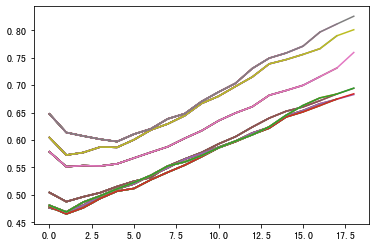

In [41]:
#find the rank that minimize the MSE
df = load_dataset(data_file, CONFIG["dataset"])
random.seed(CONFIG["seed"])
#user_item_matrix = create_matrix(df)

info_list = []
for file_name in movie_file:
    df = pd.read_csv(os.path.join(path,file_name),index_col=0)
    user_item_matrix = np.array(df)
    masked_matrix, removed_entries = remove_half_entries(user_item_matrix.copy())
    mse_list = []
    for rank in range(1,20):
        completed_matrix = hard_impute(masked_matrix, rank=rank,max_iters=100, convergence_threshold=0.0001)
        ground_truth = np.array([entry[2] for entry in removed_entries])
        imputed_values = np.array([completed_matrix[entry[0], entry[1]] for entry in removed_entries])
        mse = mean_squared_error(ground_truth, imputed_values)
        mse_list.append(mse)
        plt.plot(mse_list)
    info_list.append('In the file {}, rank = {}, min(mse)= {}'.format(file_name,mse_list.index(min(mse_list))+1,min(mse_list)))

#conclude that they are similar
info_list

### Impute Feedback

In [45]:
matrix = load_matrix_from_csv('./Feedback.csv')
imputed_matrix = hard_impute(matrix,rank = 2,max_iters=100, convergence_threshold=0.0001)
#imputed_matrix = np.round(imputed_matrix).astype(int)
completed_matrix =pd.DataFrame(imputed_matrix, index=matrix.index, columns=matrix.columns)
#save_matrix_to_csv(completed_matrix, './imputedFeedback.csv')
completed_matrix

[IterativeSVD] Iter 1: observed MAE=1.580658
[IterativeSVD] Iter 2: observed MAE=0.871172
[IterativeSVD] Iter 3: observed MAE=0.675527
[IterativeSVD] Iter 4: observed MAE=0.620626
[IterativeSVD] Iter 5: observed MAE=0.597871
[IterativeSVD] Iter 6: observed MAE=0.581934
[IterativeSVD] Iter 7: observed MAE=0.568491
[IterativeSVD] Iter 8: observed MAE=0.557061
[IterativeSVD] Iter 9: observed MAE=0.547832
[IterativeSVD] Iter 10: observed MAE=0.540629
[IterativeSVD] Iter 11: observed MAE=0.534740
[IterativeSVD] Iter 12: observed MAE=0.530374
[IterativeSVD] Iter 13: observed MAE=0.526165
[IterativeSVD] Iter 14: observed MAE=0.522267
[IterativeSVD] Iter 15: observed MAE=0.518603
[IterativeSVD] Iter 16: observed MAE=0.515211
[IterativeSVD] Iter 17: observed MAE=0.511904
[IterativeSVD] Iter 18: observed MAE=0.509246
[IterativeSVD] Iter 19: observed MAE=0.506438
[IterativeSVD] Iter 20: observed MAE=0.504130
[IterativeSVD] Iter 21: observed MAE=0.502635
[IterativeSVD] Iter 22: observed MAE=0.5014

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15
1,3.000000,2.936295,3.095111,3.000000,3.577885,3.000000,3.000000,2.974320,3.209782,3.000000,3.000000,3.457824,4.000000,3.240270,3.000000
2,4.563583,3.000000,3.000000,3.620952,3.849408,3.525939,3.000000,3.000000,4.035957,2.945496,3.000000,4.482742,5.000000,3.893455,3.000000
3,3.296840,2.748036,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.158357,2.768723,2.600258,4.000000,3.000000,3.000000,2.833534
4,4.000000,4.000000,2.925351,3.345142,3.000000,3.267340,2.782432,3.000000,3.717089,2.000000,2.527572,4.000000,4.086220,4.000000,3.052571
5,5.000000,4.706582,5.000000,5.000000,5.713658,5.032053,5.000000,4.787859,5.000000,4.878048,4.635151,5.000000,5.501428,5.080981,5.000000
6,1.000000,3.030021,4.000000,2.000000,3.585584,3.039978,4.000000,3.170768,4.000000,2.000000,3.273621,3.000000,2.818637,2.780182,2.909229
7,5.138484,2.407353,3.000000,4.000000,3.131014,3.000000,1.849585,2.250158,3.000000,2.007608,1.000000,5.000000,4.439374,3.702299,3.000000
8,2.000000,2.176995,2.364838,2.015749,4.000000,2.220237,2.572650,2.000000,1.000000,2.000000,2.299651,3.000000,1.000000,2.086254,2.000000
9,3.000000,3.227148,3.000000,3.214862,3.896233,5.000000,3.615483,3.000000,3.000000,3.394811,3.000000,3.469463,3.000000,4.000000,3.000000
10,5.142261,4.000000,4.208608,5.000000,4.992318,4.488710,4.165724,4.053777,5.000000,4.031261,3.765361,5.000000,5.301265,4.000000,5.000000
